## 🐈 Cat Emotion Classification with EfficientNet

### Import Modules

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision.models import EfficientNet_B5_Weights
from torchsummary import summary

from PIL import Image
from tqdm import tqdm

In [2]:
np.random.seed(42)

class_labels = ['angry', 'happy']
n_classes = len(class_labels)

### Set Hyperparameters

In [5]:
n_epochs: int = 50
batch_size: int = 100
learning_rate: float = 0.001

### Set Device

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

### Load Dataset (`YOLOv7` Format)

In [5]:
class YOLOv7Dataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        
        self.classes = class_labels
        self.images = [os.path.join(image_dir, x) for x in sorted(os.listdir(image_dir))]
        self.labels = [
            self._read_label(os.path.splitext(x.replace(image_dir, label_dir))[0] + '.txt') 
            for x in self.images
        ]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def _read_label(self, label_path):
        with open(label_path, 'r') as file:
            class_id = int(file.readline().strip().split()[0])
            return class_id

In [10]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
    ],
)

In [7]:
train_dataset = YOLOv7Dataset("./data/train/images", "./data/train/labels", transform=transform)
valid_dataset = YOLOv7Dataset("./data/valid/images", "./data/valid/labels", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=True)

### Show Sample Images

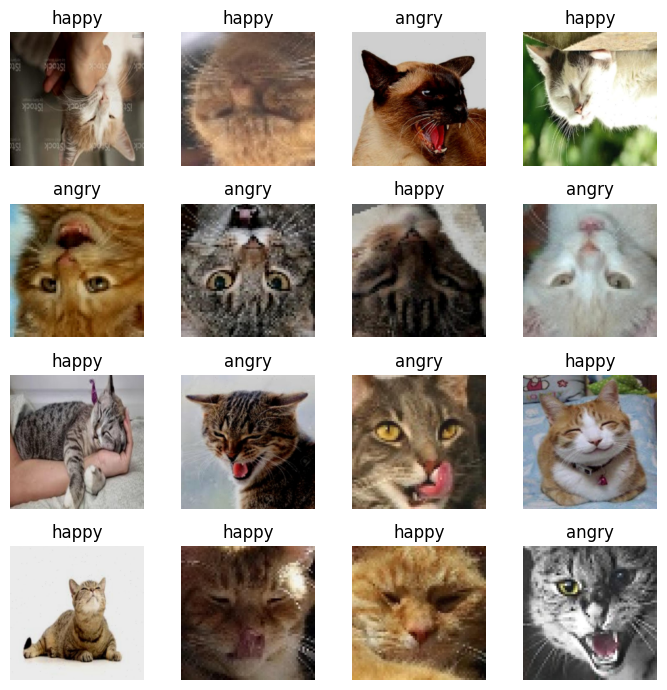

In [8]:
def show_images(images, labels, rows=4, cols=4):
    images = images.numpy().transpose((0, 2, 3, 1))
    _, axes = plt.subplots(rows, cols, figsize=(7, 7))
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] * 0.5 + 0.5)
        ax.axis("off")
        ax.set_title(train_dataset.classes[labels[i]])
    
    plt.tight_layout()

images, labels = next(iter(train_loader))
show_images(images, labels)

### Import `EfficientNet-B5`

<center>
    <img src="https://www.researchgate.net/publication/358585113/figure/fig4/AS:1123594918739968@1644897312526/A-A-concise-representation-of-the-EfficientNet-B0-model-B-The-building-blocks-of.png" height="70%" width="70%">
</center>

In [9]:
model = models.efficientnet_b5(weights=EfficientNet_B5_Weights.DEFAULT)

### Transfer Learning

In [ ]:
for param in model.parameters():
    param.requires_grad = False

n_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(n_features, n_classes)

summary(model, input_size=(3, 224, 224), batch_size=batch_size)

#### EfficientNet-B5 Summary

- Total params: `28,344,882`

- Trainable params: `4,098`

- Non-trainable params: `28,340,784`

In [11]:
model = model.to(device)

### Start Training

#### Set Loss and Optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### Train Loop

In [ ]:
running_loss_arr = []
valid_loss_arr = []

best_valid_loss = np.inf

for epoch in range(n_epochs):
    model.train()
    train_loop = tqdm(
        enumerate(train_loader), 
        total=len(train_loader), 
        desc=f"Epoch {epoch+1}/{n_epochs} Train",
    )
    
    epoch_loss_arr = []
    for batch_idx, (data, targets) in train_loop:
        data = data.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        
        scores = model(data)
        loss = criterion(scores, targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss_arr.append(loss.item())
        running_loss_arr.append(loss.item())
        
        train_loop.set_postfix(loss=np.mean(epoch_loss_arr))
    
    is_best = False
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        for data, targets in valid_loader:
            data = data.to(device)
            targets = targets.to(device)
            
            scores = model(data)
            loss = criterion(scores, targets)
            
            valid_loss += loss.item()
        
        valid_loss /= len(valid_loader)
        valid_loss_arr.append(valid_loss)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            is_best = True
        
        print(f'Validation Loss after epoch {epoch + 1}: {valid_loss:.4f}')
    
    if is_best:
        torch.save(
            { 
                "model_state_dict": model.state_dict(), 
                "optimizer_state_dict": optimizer.state_dict(), 
            },
            f=f"./model/effnet_b5_{valid_loss:.4f}.luma"
        )
        print(f"Saved model due to improvement on validation loss.")

### Plot Running Loss

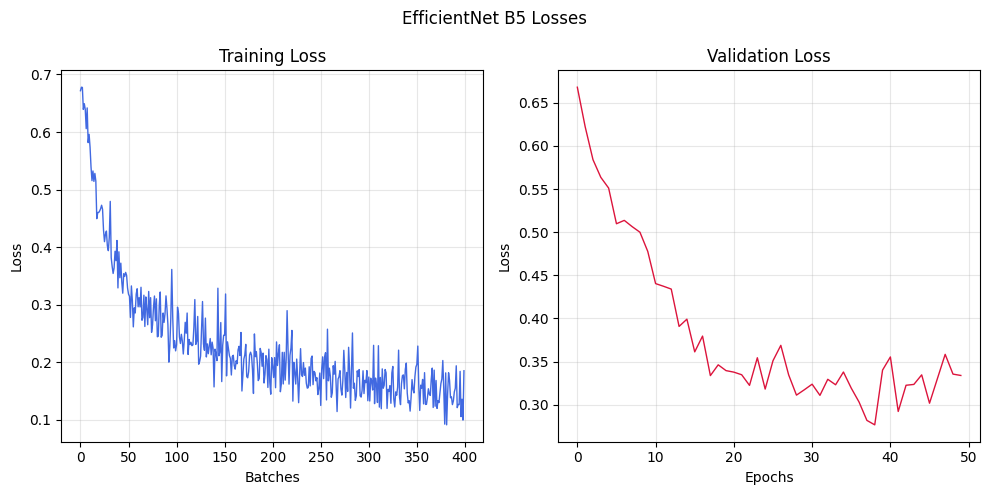

In [14]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

fig.suptitle("EfficientNet B5 Losses")

ax1.plot(running_loss_arr, lw=1, c="royalblue")
ax1.set_xlabel("Batches")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.grid(alpha=0.3)

ax2.plot(valid_loss_arr, lw=1, c="crimson")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Validation Loss")
ax2.grid(alpha=0.3)

fig.tight_layout()

### Import Best Model

In [7]:
model = models.efficientnet_b5(weights=EfficientNet_B5_Weights.DEFAULT)

n_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(n_features, n_classes)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model_path = f"./model/cat_emotion_effnet_b5.luma"
checkpoint = torch.load(model_path)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print(model_path)

./model/cat_emotion_effnet_b5.luma


In [8]:
model = model.to(device)

### Evaluate with Validation Set

In [12]:
model.eval()
_loss_arr = []
correct = 0
with torch.no_grad():
    for x, y in valid_loader:
        x = x.to(device)
        y = y.to(device)
        
        out = model(x)
        _, preds = torch.max(out, 1)
        
        correct += (preds == y).sum().item()
        _loss = criterion(out, y)
        _loss_arr.append(_loss.cpu().numpy())

_loss_avg = np.average(_loss_arr)

In [13]:
print(f"Avg. Valid. Loss: {_loss_avg},", 
      f"Accuracy: {correct / len(valid_loader.dataset) * 100} %")

Avg. Valid. Loss: 0.31504496932029724, Accuracy: 83.82352941176471 %


### Visualize Trained Weights

In [14]:
def plot_weights(weights, nrows: int, ncols: int, title: str) -> None:
    weights_min, weights_max = weights.min(), weights.max()
    weights = (weights - weights_min) / (weights_max - weights_min)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(6, 4))
    fig.suptitle(title)
    
    for i, ax in enumerate(axes.flat):
        ax.axis('off')
        if i < weights.shape[0]:
            img = weights[i].transpose((1, 2, 0))
            ax.imshow(img)
            ax.axis('off')
    
    fig.tight_layout()

#### Main Convolution Filters

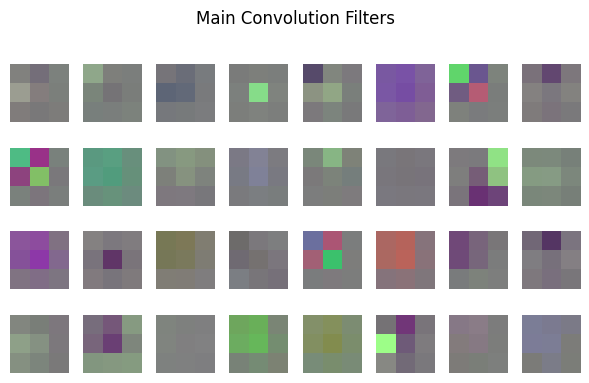

In [15]:
weights = model.features[0][0].weight.data.cpu().numpy()
plot_weights(weights, 4, 8, title="Main Convolution Filters")

#### Plot Feature Maps of the Main Convolution Layer

In [27]:
def forward_conv1(image_tensor):
    model.eval()
    with torch.no_grad():
        conv1_output = model.features[0][0](image_tensor)
    return conv1_output

def plot_feature_maps(original_img, feature_maps, n_maps):
    if torch.is_tensor(feature_maps):
        feature_maps = feature_maps.detach().cpu().numpy()
    
    rows = n_maps // 8
    fig, axes = plt.subplots(rows, 8, figsize=(9, rows * 1.2))
    
    if n_maps > 8:
        axes = axes.flatten()

    img = original_img.numpy().transpose((1, 2, 0))
    for i, ax in enumerate(axes):
        ax.axis('off')
        if i == 0:
            ax.imshow(img / 2 + 0.5)
        if i < n_maps and i > 0:
            ax.imshow(feature_maps[0, i], cmap="RdYlBu")

    fig.tight_layout()

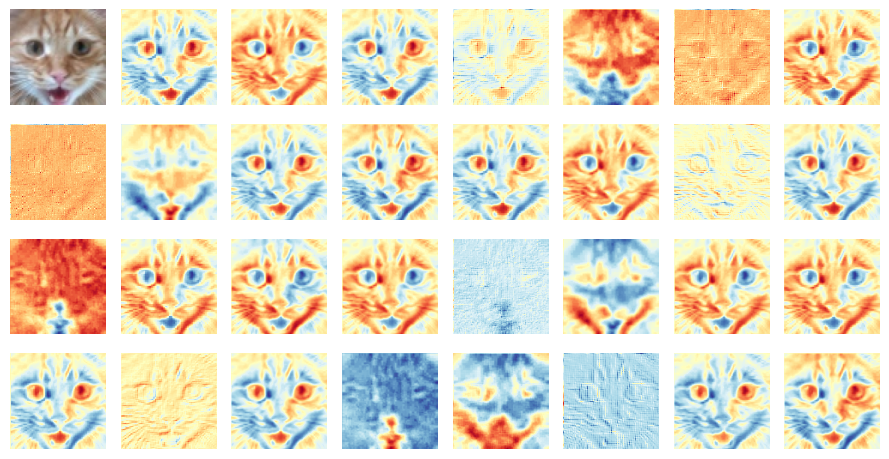

In [17]:
sample_img, _ = next(iter(train_loader))
conv1_out = forward_conv1(sample_img.to(device))

plot_feature_maps(sample_img[0], conv1_out, n_maps=32)

### Evaluate Test Dataset

#### Load Test Dataset

In [18]:
test_dataset = YOLOv7Dataset("./data/test/images", "./data/test/labels", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [51]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [52]:
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

Accuracy of the model on the test images: 97.22%


#### Confusion Matrix

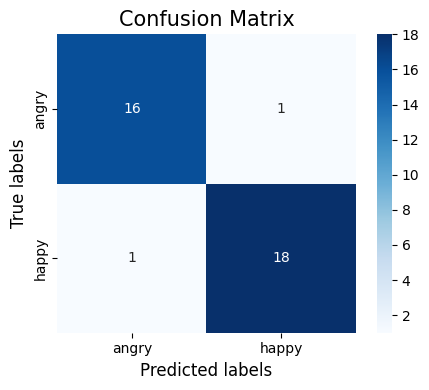

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
actuals = []
predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        actuals.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

actuals = np.array(actuals)
predictions = np.array(predictions)

cm = confusion_matrix(actuals, predictions)

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='Blues', square=True)

label_font = {'size': '12'}
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('True labels', fontdict=label_font)
ax.set_title('Confusion Matrix', fontdict={'size': 15})

ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)
plt.tight_layout()

#### Plot Sample Prediction

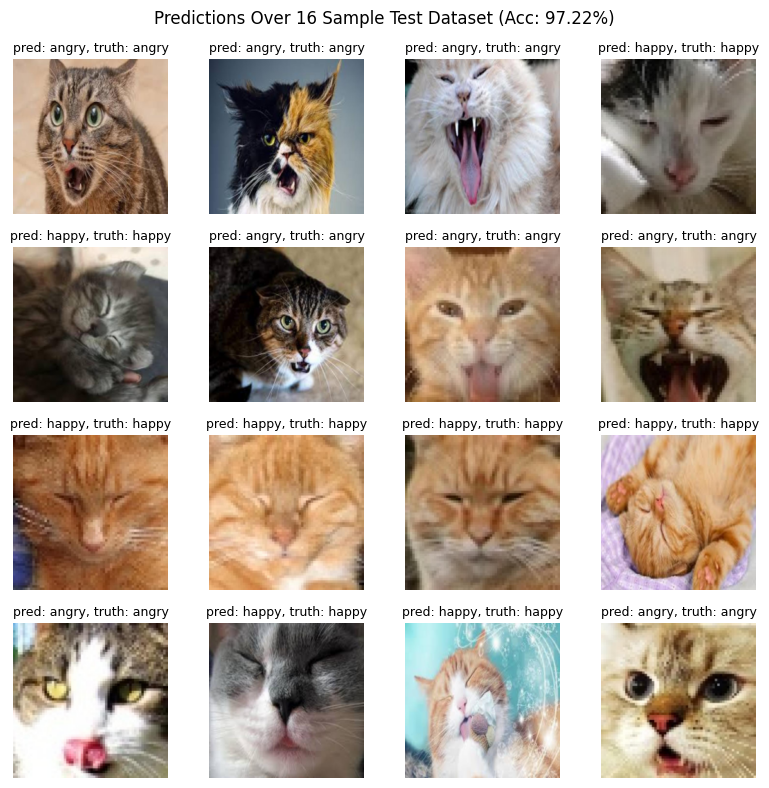

In [62]:
from torchvision.utils import make_grid

classes = {cl: label for cl, label in enumerate(class_labels)}

model.eval()
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)

_, preds = torch.max(outputs, 1)
images = images.cpu()

fig = plt.figure(figsize=(8, 8))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img_grid = make_grid(images[i]).numpy() / 2 + 0.5
    
    plt.imshow(np.transpose(img_grid, (1, 2, 0)))
    plt.axis('off')
    
    ax.set_title(f"pred: {classes[preds[i].item()]}, " 
                 + f"truth: {classes[labels[i].item()]}", fontsize=9)

fig.suptitle(f"Predictions Over 16 Sample Test Dataset " 
             + f"(Acc: {accuracy:.2f}%)")
plt.tight_layout()

### Trace Pass Forwarding Procedure via Real-World Image

#### 0️⃣ Load Image and Tensorize

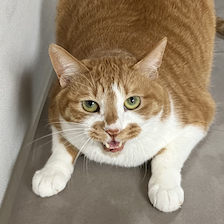

In [396]:
image = Image.open("./data/sample.png").convert('RGB')
image_tensor = transform(image).unsqueeze(0).to(device)
image

#### 1️⃣ Set-Up Hooks

In [397]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

for name, layer in model.named_children():
    layer.register_forward_hook(get_activation(name))
    
model.eval()
output = model(image_tensor)

#### 2️⃣ Set Plotting Function and Save Step-by-Step Activation

In [398]:
def plot_maps(input_img, feat_maps, size, n_maps, title, cmap='RdYlBu'):
    feat_maps = feat_maps[:n_maps]

    fig, axs = plt.subplots(size, size, figsize=(5, 5))
    fig.suptitle(title)

    axs[0, 0].imshow(input_img.numpy().transpose((1, 2, 0)) * 0.5 + 0.5)
    axs[0, 0].set_title('Original', fontsize=8)
    axs[0, 0].axis('off')

    for idx, fmap in enumerate(feat_maps):
        if idx == 0: 
            continue
        row = idx // size
        col = idx % size
        ax = axs[row, col]
        ax.imshow(fmap.cpu().detach().numpy(), cmap=cmap)
        ax.axis('off')
        
    total_plots = n_maps + 1
    for idx in range(total_plots, size ** 2):
        row = idx // size
        col = idx % size
        axs[row, col].axis('off')

    plt.tight_layout()

In [399]:
n_blocks = len(model.features)

out = image_tensor
outputs = [out]
for i in range(n_blocks):
    out = model.features[i](out)
    outputs.append(out)

#### 3️⃣ Plot First Activation

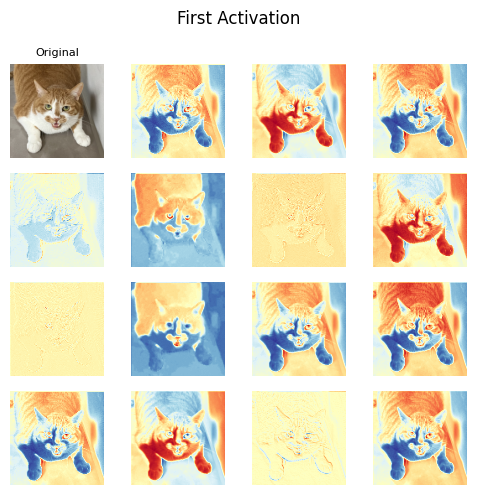

In [400]:
n = 0
plot_maps(
    input_img=image_tensor[0].cpu(),
    feat_maps=model.features[n][0](outputs[n])[0],
    size=4,
    n_maps=16,
    title="First Activation",
)

#### 4️⃣ Plot Third Activation

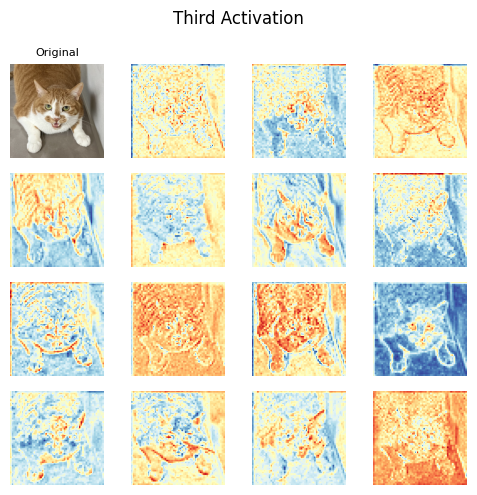

In [401]:
n = 2
plot_maps(
    input_img=image_tensor[0].cpu(),
    feat_maps=model.features[n][0](outputs[n])[0],
    size=4,
    n_maps=16,
    title="Third Activation",
)

#### 5️⃣ Plot Fifth Activation

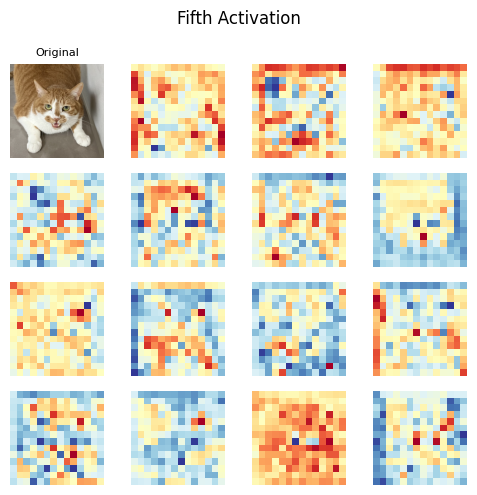

In [402]:
n = 4
plot_maps(
    input_img=image_tensor[0].cpu(),
    feat_maps=model.features[n][0](outputs[n])[0],
    size=4,
    n_maps=16,
    title="Fifth Activation",
)

#### 6️⃣ Plot Seventh Activation

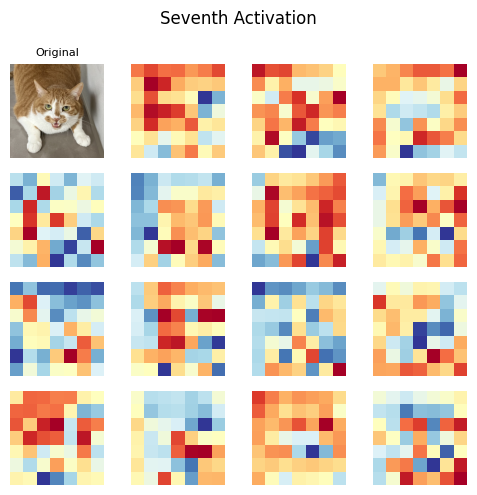

In [403]:
n = 6
plot_maps(
    input_img=image_tensor[0].cpu(),
    feat_maps=model.features[n][0](outputs[n])[0],
    size=4,
    n_maps=16,
    title="Seventh Activation",
)

#### 7️⃣ Plot Nineth Activation

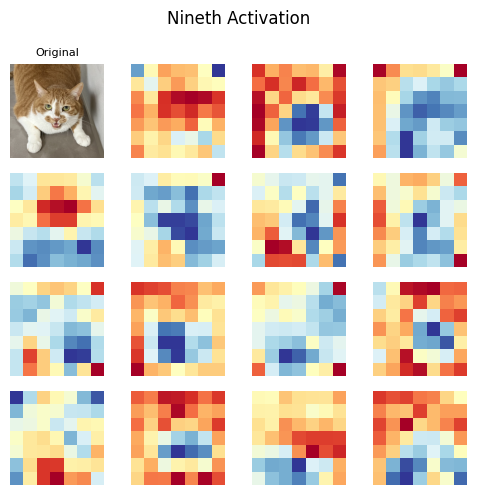

In [404]:
n = 8
plot_maps(
    input_img=image_tensor[0].cpu(),
    feat_maps=model.features[n][0](outputs[n])[0],
    size=4,
    n_maps=16,
    title="Nineth Activation",
)

#### 8️⃣ Plot Classifier's Neuron Activation

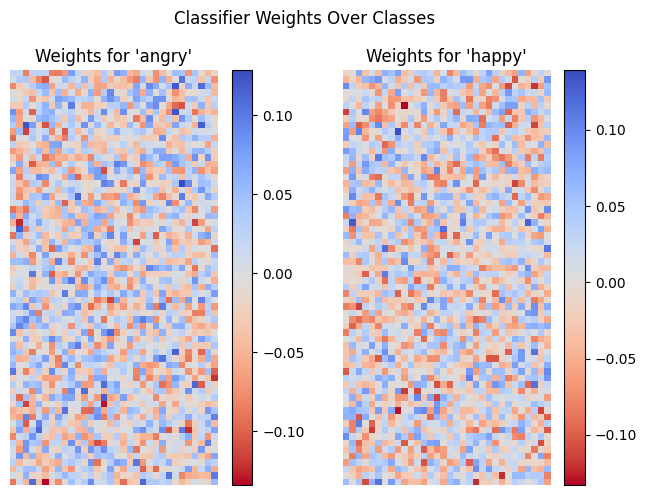

In [405]:
clf_weights = model.classifier[1].weight.detach().cpu().numpy().reshape(2, 64, 32)

fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

im1 = ax1.imshow(clf_weights[0], cmap="coolwarm_r")
ax1.set_title("Weights for 'angry'")
ax1.axis("off")

im2 = ax2.imshow(clf_weights[1], cmap="coolwarm_r")
ax2.set_title("Weights for 'happy'")
ax2.axis("off")

fig.suptitle("Classifier Weights Over Classes")
fig.colorbar(im1, ax=ax1,fraction=0.09)
fig.colorbar(im2, ax=ax2,fraction=0.09)
fig.tight_layout()

#### 📊 Show Final Prediction

In [406]:
def softmax(logits):
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits)

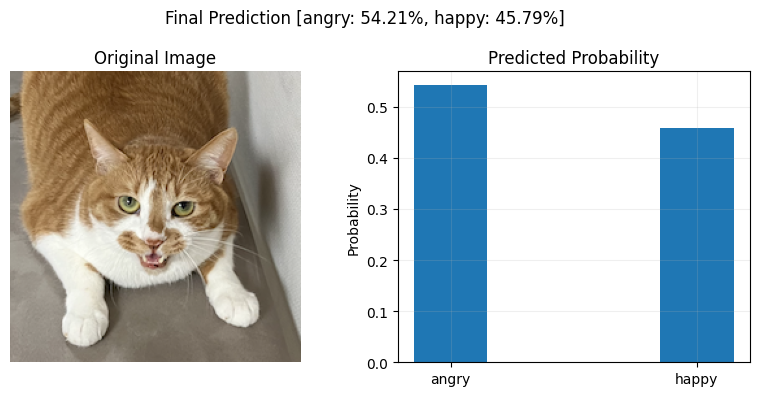

In [408]:
pred = model(image_tensor)
pred = pred.detach().cpu().numpy().flatten()
prob = softmax(pred)

image_np = image_tensor[0].detach().cpu().numpy()
image_np = image_np.transpose(1, 2, 0)
image_np = image_np * 0.5 + 0.5

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(image_np)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.bar(class_labels, prob, width=0.3)
ax2.set_ylabel("Probability")
ax2.set_title("Predicted Probability")
ax2.grid(alpha=0.2)

title = f"angry: {prob[0] * 100:.2f}%, happy: {prob[1] * 100:.2f}%"

fig.suptitle(f"Final Prediction [{title}]")
fig.tight_layout()